# Scattering cross-section calculation

To run this notebook from your browser, click [this link](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/a86bc42d97aceaf6ad31b83f14408bd808e38795?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FNear2FarSphereRCS.ipynb).

This tutorial will show you how to compute the radar cross section (RCS) for a dielectric sphere by sampling scattered near fields on a closed surface surrounding the sphere, and transforming them to observation points far away.

This example demonstrates the usefulness of the near field to far field transformation for reducing the simulation size needed for structures involving lots of empty space.

To obtain the scattered field, we will run two simulations:
* one with the sphere to compute the total near field on a closed surface around the sphere, and
* one without the sphere, to compute just the incident field and subtract it from the above to get the scattered field.

Then, we'll show how to use the [Near2Far](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Near2Far.html) feature from `Tidy3D` to compute the RCS for the sphere using the near field data.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

## Define Simulation Parameters

We first need to define our simulation parameters and the structure.

In [2]:
# radius and location of the sphere
radius = 0.5
center = [0, 0, 0]

# permittivity of the sphere
epsr = 4

# free space central wavelength
wavelength = (2.0 * radius) / 2.0
f0 = td.C_0 / wavelength

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 3 * wavelength

# distance between the sphere and the near field monitor along each cartesian direction
buffer_mon = 1 * wavelength

# Define material properties
air = td.Medium(permittivity=1)
diel = td.Medium(permittivity=epsr)

# resolution control
grids_per_wavelength = 40

# create the sphere
sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=diel)
geometry = [sphere]

# grid size (um)
dl = wavelength / grids_per_wavelength

# define PML layers
pml_layers = 3*[td.PML()]

# set the domain size in x, y, and z
domain_size = buffer_PML + 2 * radius + buffer_PML

# construct simulation size array
sim_size = (domain_size, domain_size, domain_size)

## Create Source

For our incident field, we create a plane wave incident from below the sphere polarized in the x direction.

In [3]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# place the source below the sphere, propagating in the +z direction
source = td.PlaneWave(
    center=(0,0,-(radius + 3 * buffer_PML / 4)),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction='+',
    pol_angle=0)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 50 / fwidth


## Create Monitor

Next, we define the monitors that will capture the near field data.

First, we create a [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=FielDmonitor) completely enclosing the sphere.

The, using the `.surfaces()` method, we can extract the 6 planar surfaces surrounding the volume and feed these to the simulation.

This cuts down on the data required vs computing the full volume because only the fields on the enclosing surface are required to get the far field information.

In [4]:
# create a volume monitor around the sphere
mon_size = 2 * radius + 2 * buffer_mon
#mon_size = wavelength
monitor = td.FieldMonitor(
    center=center,
    size=[mon_size, mon_size, mon_size],
    freqs=[f0],
    name='near_field')

# get the surface monitors associated with the volume monitor
monitors = monitor.surfaces()

## Create Simulation

Now we can put everything together and define the two simulation classes: with the sphere to get the total field, and without the sphere to get the incident field.

In [5]:
sim = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    pml_layers=pml_layers
)

sim_empty = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=[],
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    pml_layers=pml_layers
)

## Visualize Geometry

Let's take a look and make sure everything is defined properly in both simulations.

<Figure size 648x216 with 4 Axes>

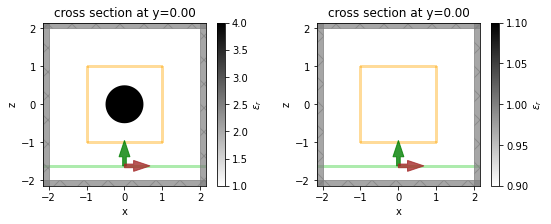

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim.plot_eps(y=0, ax=ax1);
sim_empty.plot_eps(y=0, ax=ax2);

## Run Simulations

Now we can run both simulations over time and measure the results


In [7]:
# Run simulation
import tidy3d.web as web

sim_data = web.run(sim, task_name='sphereRCS', path='data/sphereRCS.hdf5')
sim_empty_data = web.run(sim_empty, task_name='sphereRCS_empty', path='data/sphereRCS_empty.hdf5')

# compute scattered fields by subtracting out the incident fields from the empty simulation
for mon in monitors:
    sim_data[mon.name].Ex -= sim_empty_data[mon.name].Ex
    sim_data[mon.name].Ey -= sim_empty_data[mon.name].Ey
    sim_data[mon.name].Ez -= sim_empty_data[mon.name].Ez

    sim_data[mon.name].Hx -= sim_empty_data[mon.name].Hx
    sim_data[mon.name].Hy -= sim_empty_data[mon.name].Hy
    sim_data[mon.name].Hz -= sim_empty_data[mon.name].Hz

[23:11:25] INFO     Using Tidy3D credentials from stored file                      ]8;id=680891;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=441992;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#74\74]8;;\

[23:11:27] INFO     Uploaded task 'sphereRCS' with task_id                      ]8;id=613317;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=497594;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'bb4682b8-55f3-48d4-82e9-e5b82b2e3e5d'.                                  

[23:11:29] INFO     Maximum flex unit cost: 0.42                                ]8;id=111517;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=248075;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

/usr/local/lib/python3.9/site-packages/rich/live.py:221: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[23:11:37] INFO     status = preprocess                                         ]8;id=301246;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=30811;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[23:11:58] INFO     starting up solver                                          ]8;id=481500;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=570769;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[23:13:41] INFO     running solver                                              ]8;id=592434;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=591818;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

[23:14:33] INFO     early shutoff detected, exiting.                            ]8;id=918994;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=617419;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

[23:14:37] INFO     status = postprocess                                        ]8;id=869305;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=432436;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[23:15:05] INFO     status = success                                            ]8;id=662026;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=98789;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#296\296]8;;\

[23:15:06] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=522340;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=431391;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sphereRCS.hdf5"                                                    

[23:15:09] INFO     loading SimulationData from data/sphereRCS.hdf5             ]8;id=1320;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=546395;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[23:15:12] INFO     Uploaded task 'sphereRCS_empty' with task_id                ]8;id=407510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=329823;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '9b1ad976-75da-4b1a-8568-a88b5906a70b'.                                  

[23:15:14] INFO     Maximum flex unit cost: 0.42                                ]8;id=808430;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=862170;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

[23:15:23] INFO     status = preprocess                                         ]8;id=803242;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=954627;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[23:15:46] INFO     starting up solver                                          ]8;id=157635;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=380829;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[23:16:14] INFO     running solver                                              ]8;id=906472;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=400974;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

[23:16:18] INFO     early shutoff detected, exiting.                            ]8;id=843696;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=881216;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

[23:16:21] INFO     status = postprocess                                        ]8;id=409244;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=292705;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[23:16:46] INFO     status = success                                            ]8;id=314505;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=48651;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[23:16:50] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=781680;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=621637;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sphereRCS_empty.hdf5"                                              

[23:16:52] INFO     loading SimulationData from data/sphereRCS_empty.hdf5       ]8;id=265193;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=829389;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

## Setting Up Near2Far

To set up the near-to-far transformation, we need to grab the fields on each surface of the near-field [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html) objects.

So, we simply create a [Near2Far](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Near2Far.html) object and pass in the surface monitors as shown below.  Note that we also need to pass the normal directions of each of the monitors in the list.

In addition to storing the near field data, this object will compute he surface currents and provide various methods for projecting the far field quantities.

We can optionally pass in the number of points per wavelength in the background medium with which to sample fields on the monitors. The default is 10 points per wavelength.

One can also pass in coordinates for the local origin of the set of monitors; the far-field observation points will be defined with respect to this origin. By default, the local origin is set to the average of the centers of all surface monitors passed in.

In [8]:
from tidy3d.plugins import Near2Far

n2f = Near2Far.from_surface_monitors(
    sim_data=sim_data, 
    monitors=monitors, 
    normal_dirs=['-','+','-','+','-','+'], 
    frequency=f0, 
    pts_per_wavelength=10
)

## Getting Far Field Data

After the `Near2Far` object is initialized, each of its surface surface currents are computed.

Then, we just need to call one of its methods to get a far field quantity.

For this example, we use `Near2Far.radar_cross_section(r,theta,phi)` to get the RCS at an `r,theta,phi` point relative to the center of the original monitor.

Note that this can be set or verified using the `Near2Far.origin` attribute.

In [9]:
print(f'origin at {n2f.origin}')

origin at (0.0, 0.0, 0.0)


In [10]:
far_distance = 100 * wavelength

num_theta = 300
num_phi = 2
thetas = np.linspace(0, np.pi, num_theta)
phis = np.linspace(0, np.pi/2, num_phi)

RCS = n2f.radar_cross_section(thetas, phis).values

/usr/local/lib/python3.9/site-packages/rich/live.py:221: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

## Plot Results
Now we can plot the RCS and compare it to the analytical RCS computed via the Mie series.

The results match quite well, but there are some errors due to approximations inherent to the near field to far field transformation.

<Figure size 540x360 with 1 Axes>

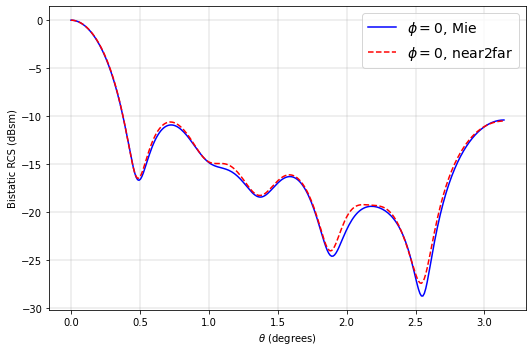

<Figure size 540x360 with 1 Axes>

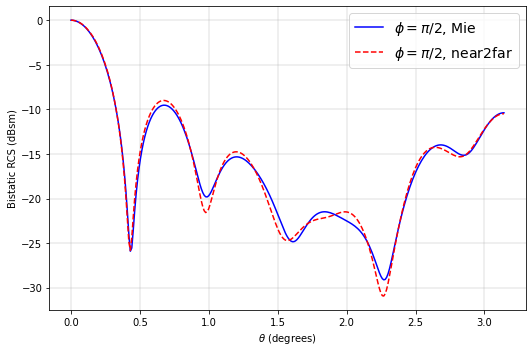

In [11]:
def to_db(val):
    val = val / np.max(np.abs(val))
    return 10.0*np.log10(val)

RCS_phi0 = np.squeeze(RCS[:,0])
RCS_phi90 = np.squeeze(RCS[:,1])

# ------ import analytical data from disk ------

mie_file_id = '2lambda_epsr4'
mie_filename_phi0 = "./data/mie_bRCS_phi0_" + mie_file_id + ".txt"
mie_filename_phi90 = "./data/mie_bRCS_phi90_" + mie_file_id + ".txt"

mie_data_phi0 = np.loadtxt(mie_filename_phi0, delimiter='\t', skiprows=2)
mie_theta_phi0 = np.squeeze(mie_data_phi0[:,[0]])
mie_phi0 = np.squeeze(mie_data_phi0[:,[1]])

mie_data_phi90 = np.loadtxt(mie_filename_phi90, delimiter='\t', skiprows=2)
mie_theta_phi90 = np.squeeze(mie_data_phi90[:,[0]])
mie_phi90 = np.squeeze(mie_data_phi90[:,[1]])

# ------ plot for phi = 0 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi0, to_db(mie_phi0), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, to_db(RCS_phi0), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ plot for phi = pi/2 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi90, to_db(mie_phi90), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, to_db(RCS_phi90), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

